In [1]:
import numpy as np
import math
import xarray as xr
import pandas as pd
import scipy
import matplotlib as mpl
import argparse
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import (
    LinearSegmentedColormap,
    BoundaryNorm,
    ListedColormap,
    LogNorm,
)
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
# ## Feeding

# parser = argparse.ArgumentParser()

# parser.add_argument(
#     "-v",
#     "--variable",
#     help="the current variable implemented are ['temp_val', 'rain_rate_max', 'slp', 'wind_speed', 'rel_hum']",
# )
# parser.add_argument("-d", "--date", help="Use bash command 'date +%Y%m%d_%H%M' ")
# parser.add_argument(
#     "-i", "--input", required=False, help="the data-input folder", default="data/"
# )
# parser.add_argument(
#     "-o", "--output", required=False, help="the output folder", default="maps/"
# )
# # parser.print_help()
# args = parser.parse_args()


# exit()
# print(args.input, args.output)
# Defining variables
variabili = ["temp_val", "rain_rate_max", "slp", "wind_speed", "rel_hum"]
variable = "rain_rate_max"
date='20230518_1820'
# if args.variable not in variabili:
#     print(f"{args.variable} is not present in the variable list")
#     exit()



In [7]:
##########
# Reading input
try:
    dem = xr.open_dataset(f"data/geo-data/dem100.nc")
except:
    print("Something went wrong, can't find dem file")
    exit()
try:
    df = pd.read_csv(f"data/dati_20230518_1820.csv", na_values="NA")
    df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs='EPSG:4326').to_crs('EPSG:32632')

except:
    print("Something went wrong, can't find data file")
    exit()

fname = f"data/geo-data/comuni_reggio_Emilia.shp"

In [10]:
temp = {
    'name': 'temp_val',
    'levels': np.array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]),
    'colors': ['#4D005B', '#53006D', '#560088', '#570096', '#5400A8', '#4C00BF', '#4200D1', '#2E00E8', '#2100FA', '#000FFF', 
            '#0027FF', '#0046FF', '#0064FF', '#007CFF', '#009BFF', '#00B9FF', '#00D1FF', '#00F0FF', '#00FAF0', '#01F3DB',
            '#02EABE', '#03E1A0', '#04DA8B', '#05D16E', '#06C850', '#07C13B', '#08B81E', '#2CBE0D', '#49C70B', '#66D009', 
            '#7CD708', '#99E006', '#AFE605', '#CCEF03', '#E9F801', '#FFFF00', '#FFF400', '#FFE900', '#FFE100', '#FFD600', 
            '#FFCB00', '#FFC300', '#FFB800', '#FFAD00', '#FFA500', '#FF9100', '#FF7D00', '#FF6E00', '#FF5A00', '#FF4600', 
            '#FF3700', '#FF2300', '#FF0F00', '#EB0010', '#DB001D', '#C7002D', '#B3003E', '#A3004A', '#8F005B', '#7B006B', '#6B0078'],
    'offset': 273,
    'lower_c': "#41004d",
    'over_c' : "#72299B",
    'space': 5}
prp = {
    'name': 'rain_rate_max', 
    'levels': np.array([0.2, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100, 125, 150, 175, 200, 250, 300]),
    'colors': ['#C0C0C0', '#D6E2FF', '#B5C9FF', '#8EB2FF', '#7F96FF', '#6370F7', '#009E1E' , '#3CBC3D','#B3D16E', '#B9F96E', '#FEFEA0', '#FFF914', '#FFA30A', '#E50000', '#BD0000', '#D464C3', '#B5199D', '#840094', '#B4B4B4', '#8C8C8C', '#5A5A5A'],
    'offset': 0,
    'lower_c': "#a6a6a6",
    'over_c' : "#4d4d4d",
    'space': 10}
wind = {
    'name': 'wind_speed', 
    'levels': np.array([0.5,2.5,5,11,19,30,39,50,61,74,87,102,117]),
    'colors': [ "#C0C0C0", "#EEFFFF", "#96D2FA", "#50A5F5", "#196EE1", "#00D278", "#00A000", "#E11400", "#A50000", "#FF00FF", "#FFAAFF", "#FF9600", "#AAAAAA"],
    'offset': 0,
    'lower_c': "#a6a6a6",
    'over_c' : "#999999",
    'space': 10}
rh = {
    'name': 'rel_hum', 
    'levels': np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
    'colors': ["#C0C0C0", "#C8000F", "#E16600", "#F2BB00", "#E9FA00", "#67D700", "#04B400", "#00F5E9", "#16D5CE", "#2CA890", "#1D6DA5", "#4C00B3",],
    'offset': 0,
    'lower_c': "#a6a6a6",
    'over_c' : "#400099",
    'space': 20}

meteo_set = {
  "temp_val" : temp,
  "rain_rate_max" : prp,
  "wind_speed" : wind,
  "rel_hum" : rh,
}

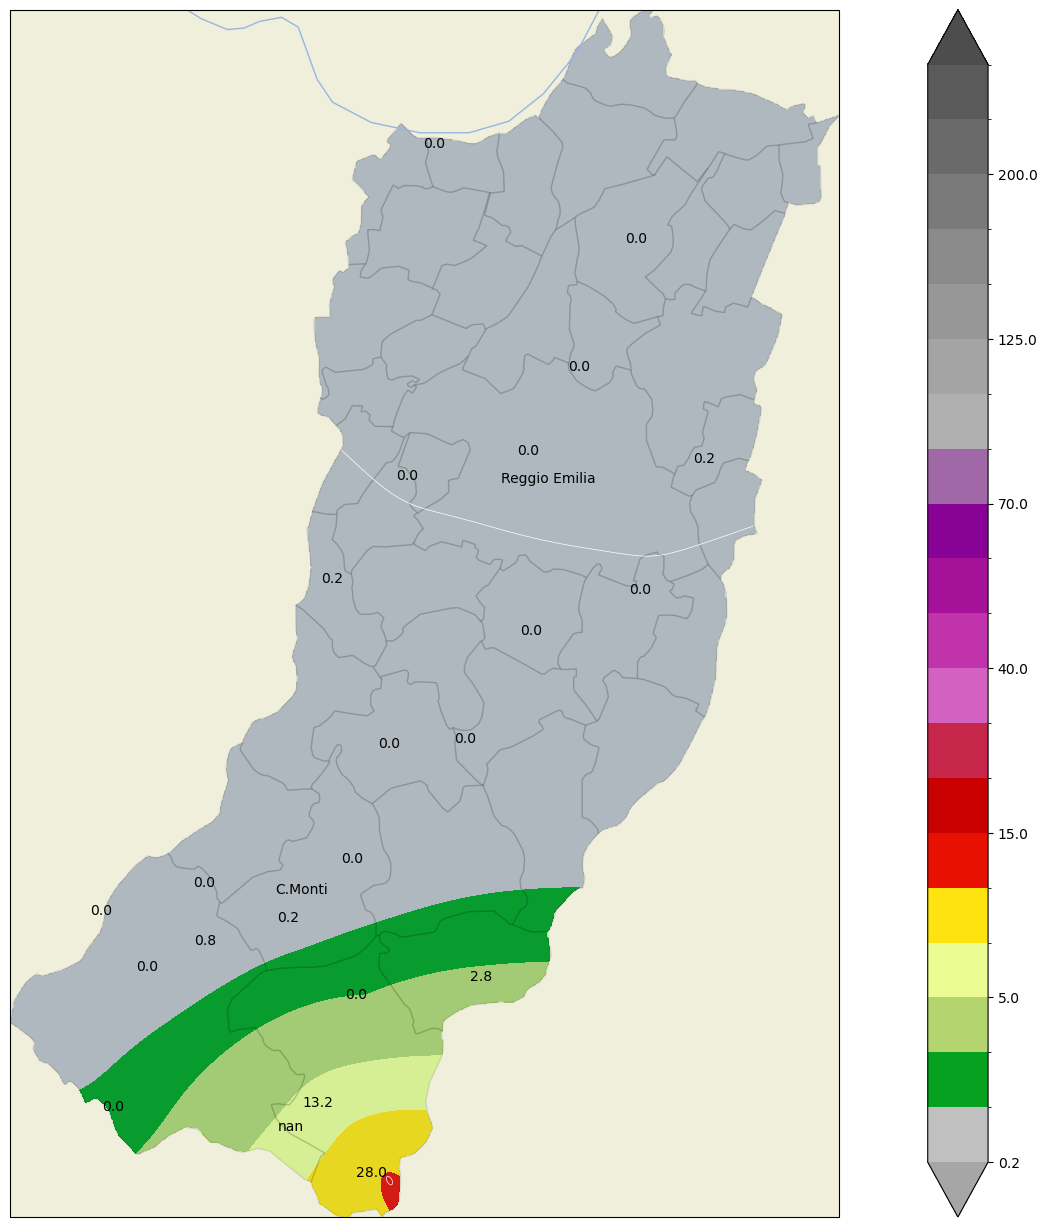

In [11]:
class MeteoMap:
  def __init__(self, meteo_set, parsed_variable, input_dem, parsed_date, input_gdf):
    self.name = meteo_set[parsed_variable]['name']
    self.levels = meteo_set[parsed_variable]['levels']
    self.colors = meteo_set[parsed_variable]['colors']
    self.offset= meteo_set[parsed_variable]['offset']
    self.over_c = meteo_set[parsed_variable]['over_c']
    self.lower_c = meteo_set[parsed_variable]['lower_c']
    self.space = meteo_set[parsed_variable]['space']
    self.dem = input_dem
    self.date= parsed_date
    self.gdf=input_gdf
    # self.interp_var = np.full([input_dem.Band1.values.shape[0], input_dem.Band1.values.shape[1]], np.nan)
    self.var2int = np.array([input_gdf[self.name][:]])[0] + self.offset

     
######################
######### OK #########
######################
  def palette_attribute(self):
    lev_norm = (self.levels-self.levels[0])/(self.levels[-1]-self.levels[0])
    cmap = mpl.colors.LinearSegmentedColormap.from_list(self.name,list(zip(lev_norm,self.colors)))#,N=len(self.levels))
    norm= mpl.colors.BoundaryNorm(self.levels, cmap.N)
    return lev_norm, cmap, norm
  
  def get_coordinates(self):    
     grid_elevation = dem.Band1.values 
     elev = np.array([self.gdf.quota])
     grid_lon = self.dem.x.values
     grid_lat = self.dem.y.values
     station_coordinates = np.dstack([np.array([self.gdf.geometry.x]),np.array([self.gdf.geometry.y]),np.array([self.gdf.quota])])[0]
    #  dem_coordinates = np.array([[grid_lon[j], grid_lat[i]]])
     return station_coordinates, grid_lon, grid_lat, grid_elevation, elev

######################
######### OK #########
######################
## Defining functions
  def compute_distance_weight(self,station_coordinates, grid_coordinates):
    # passo array coordinate stazione e del singolo punto
    dist = (
        abs(scipy.spatial.distance.cdist(station_coordinates, grid_coordinates).T[0]) / 10000
    )  # pick the appropriate distance metric
    dist_w = np.exp(-dist)
    return dist_w

######################
######### OK #########
######################
  def compute_elevation_weight(self, z_stations, z_grid):
    if np.isnan(z_grid) == False:
        disl = abs(z_stations - z_grid) / 500  # pick the appropriate distance metric
        dist_z = np.exp(-disl[0])
    else:
        dist_z = 1
    return dist_z

######################
######### OK #########
######################
  def compute_weighted_var(self, d_w, z_w, T):
    weights = d_w * z_w * T
    weighted_var = np.nansum(weights) / (np.nansum(d_w * z_w))
    return weighted_var

    # cmap_temp
# interp_var = interp_var - 273
# interp_var = np.full([dem.Band1.values.shape[0], dem.Band1.values.shape[1]], np.nan)

# Interpolation
  def interpolator(self, station_coordinates, grid_longitude, grid_latitude, grid_elevation,elev): 
    field=np.full([grid_elevation.shape[0], grid_elevation.shape[1]], np.nan) #self.interp_var
    for i in range(grid_elevation.shape[0]):
        for j in range(grid_elevation.shape[1]):
            if np.isnan(grid_elevation[i][j]) == False:
                d_w = self.compute_distance_weight(station_coordinates[:,:2], np.array([[grid_longitude[j], grid_latitude[i]]]))
                if self.name == "temp_val":
                    z_w = self.compute_elevation_weight(elev, grid_elevation[i][j])
                else:
                    z_w = 1
                field[i, j] = self.compute_weighted_var(d_w, z_w, self.var2int)
            else:
                # self.interp_var[i, j] = np.nan
                field[i, j] = np.nan
    field = field-self.offset
    return field
  
  def main(self,station_coordinates, grid_longitude, grid_latitude, field):
    fig = plt.figure(figsize=(dem.Band1.shape[0] / 75*2 , dem.Band1.shape[1] / 75*2 ))
    shape_feature = ShapelyFeature(
        Reader(fname).geometries(), ccrs.epsg(32632), edgecolor="k", alpha=0.1
    )
    # Setup a global EckertIII map with faint coastlines.
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.epsg(32632))
    ax.add_feature(shape_feature)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    lev_norm, cmap, norm = meteoMap.palette_attribute()

    # And black line contours.
    line_c = ax.contour(
        grid_longitude,
        grid_latitude,
        field,
        levels=np.arange(self.levels[0],self.levels[-1],self.space), #self.levels,
        vmin=self.levels[0],
        vmax=self.levels[-1],  # filled_c.levels,
        colors=["white"],
        linewidths=0.5,
        extend="both",
    )

    filled_c = ax.contourf(
       grid_longitude, 
       grid_latitude,        
       field,
       cmap=cmap,
       levels=self.levels,
       norm=norm,
       vmin=self.levels[0],
       vmax=self.levels[-1],
       extend="both",
    )
    filled_c.cmap.set_under(self.lower_c, alpha=1)
    filled_c.cmap.set_over(self.over_c, alpha=1)
    
    fig.colorbar(filled_c, orientation="vertical", extend="both")#,spacing='uniform',ticks= levels)
    
    for t in range(len(station_coordinates)):
       plt.text(
          station_coordinates[t,0],
          station_coordinates[t,1],
          self.gdf[self.name].iloc[t],
          horizontalalignment="right",
          transform=ccrs.epsg(32632),
          )

    plt.text(
        632474, #self.gdf[self.gdf['stazione']=='Reggio Emilia'].geometry.x+4000,
        4.949993e+06, #self.gdf[self.gdf['stazione']=='Reggio Emilia'].geometry.y-2000,
        'Reggio Emilia',
        horizontalalignment="right",
        transform=ccrs.epsg(32632),
    )
    # print('REggio',self.gdf[self.gdf['stazione']=='Reggio Emilia'].geometry.x+4000,self.gdf[self.gdf['stazione']=='Reggio Emilia'].geometry.y-2000,)

    plt.text(
        613537, #self.gdf[self.gdf['stazione']=='Carnola - C.Monti'].geometry.x+2000,
        4.920955e+06, #self.gdf[self.gdf['stazione']=='Carnola - C.Monti'].geometry.y+2000,
        'C.Monti',
        horizontalalignment="right",
        transform=ccrs.epsg(32632),
    )
    # print('Carnola',self.gdf[self.gdf['stazione']=='Carnola - C.Monti'].geometry.x+2000,self.gdf[self.gdf['stazione']=='Carnola - C.Monti'].geometry.y+2000)


    # Use the line contours to place contour labels.
    # ax.clabel(
    #     line_c,  # Typically best results when labelling line contours.
    #     colors=["black"],
    #     levels=line_c.levels,
    #     manual=False,  # Automatic placement vs manual placement.
    #     inline=True,  # Cut the line where the label will be placed.
    #     fmt=" {:.0f} ".format,  # Labes as integers, with some extra space.
    # )
    fig.savefig(
        f"maps/mappa_{self.name}_{self.date}.png",
        bbox_inches="tight",
        transparent=False,
    ) 

if __name__ == "__main__":
    meteoMap = MeteoMap(meteo_set, parsed_variable= variable, input_dem=dem, parsed_date=date, input_gdf=df_geo)
    station_coordinates, grid_longitude, grid_latitude, grid_elevation, elev = meteoMap.get_coordinates()
    field = meteoMap.interpolator(station_coordinates, grid_longitude, grid_latitude, grid_elevation, elev)
    lev_norm, cmap, norm = meteoMap.palette_attribute()
    meteoMap.main(station_coordinates, grid_longitude, grid_latitude,field)

